In [2]:
!pip3 install torch==1.11.0+cu113 torchvision==0.12.0+cu113 --extra-index-url https://download.pytorch.org/whl/cu113


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 GB 657.4 kB/s eta 0:00:000:0100:04
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 10.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0
    Uninstalling torchvision-0.12.0:
      Successfully uninstalled torchvision-0.12.0


In [1]:
import os
import pickle
import numpy as np
import torch
import torchvision
from skimage import io
import time
import copy

from sklearn.metrics import f1_score
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets, models, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision.io import read_image
from collections import Counter

from matplotlib import colors, pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import math
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 232
# работаем на видеокарте
DEVICE = torch.device("cuda")
N_CORES = 2
BATCH_SIZE = 32

Создадим класс для загрузки датасета. Для удобства добавим метод tagets для получения таргетов. Также добавим к нашим картинам аугментации, чтобы бороться с дисбалансов классов.

In [4]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
    
    def targets(self):
        return self.label_encoder.transform(self.labels)
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform_train = transforms.Compose([
            transforms.RandomChoice([
                transforms.Compose([
                transforms.Resize(size=300, max_size=301),
                transforms.CenterCrop(size=300),
                transforms.RandomCrop(250)
                ]),
                transforms.RandomRotation(degrees=(-25, 25)),
                transforms.RandomHorizontalFlip(p=1)
        ]),
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        transform_val = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        test_transforms = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
        ])
        x = self.load_sample(self.files[index])
#         x = self._prepare_sample(x)
        if self.mode == 'test':
            x = test_transforms(x)
            return x
        elif self.mode == 'train':
            x = transform_train(x)
        else:
            x = transform_val(x)
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()
        return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [5]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [6]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
# api_token = {"username":"****","key":"****"}
import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c journey-springfield


 98%|████████████████████████████████████████▏| 511M/521M [00:02<00:00, 235MB/s]
100%|█████████████████████████████████████████| 521M/521M [00:02<00:00, 194MB/s]


In [7]:
! unzip journey-springfield.zip 

Archive:  journey-springfield.zip
  inflating: characters_illustration.png  
  inflating: sample_submission.csv   
  inflating: testset/testset/img0.jpg  
  inflating: testset/testset/img1.jpg  
  inflating: testset/testset/img10.jpg  
  inflating: testset/testset/img100.jpg  
  inflating: testset/testset/img101.jpg  
  inflating: testset/testset/img102.jpg  
  inflating: testset/testset/img103.jpg  
  inflating: testset/testset/img104.jpg  
  inflating: testset/testset/img105.jpg  
  inflating: testset/testset/img106.jpg  
  inflating: testset/testset/img107.jpg  
  inflating: testset/testset/img108.jpg  
  inflating: testset/testset/img109.jpg  
  inflating: testset/testset/img11.jpg  
  inflating: testset/testset/img110.jpg  
  inflating: testset/testset/img111.jpg  
  inflating: testset/testset/img112.jpg  
  inflating: testset/testset/img113.jpg  
  inflating: testset/testset/img114.jpg  
  inflating: testset/testset/img115.jpg  
  inflating: testset/testset/img116.jpg  
  inflati

In [8]:
TRAIN_DIR = Path('./train/simpsons_dataset')
TEST_DIR = Path('./testset/testset')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))


In [9]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [10]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

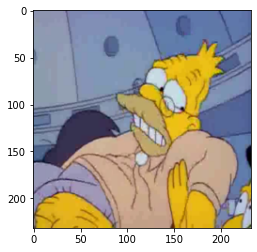

In [11]:

imshow(train_dataset[0][0])

In [12]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        del outputs, loss, preds
    scheduler.step()
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [13]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0    
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [73]:
def train(train_files, val_files, model,train_sampler, epochs, batch_size):
    train_loader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE, num_workers=N_CORES)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f}\
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f} overfitting - {step1:0.4f}/7 lossincrease - {step2:0.4f}/5"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            early_stopping(train_loss, val_loss )
            if early_stopping.early_stop:
                print("Stop learning, epoch:", epoch + 1)
                return history
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc, step1=early_stopping.get_step()[0], step2=early_stopping.get_step()[1]))
            
    return history

In [16]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            # inputs = inputs.to(DEVICE)
            inputs = inputs.to(DEVICE)

            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Посмотрим на распределение классов на обучающем датасете и заметим, что классы не сбалансированы, поэтому воспользуемся WeightedRandomSampler

In [17]:
class_count = Counter(train_dataset.targets())
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_dataset)
for i, (data, label) in enumerate(tqdm(train_dataset)):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight

N = max(class_count.values()) * len(class_count)  # fit to max
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)

100%|██████████| 15699/15699 [01:37<00:00, 160.69it/s]


Также во время обучения будем пользоваться ранней остановкой

In [78]:
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter_over = 0
        self.counter_loss = -1
        self.early_stop = False
        self.prew_loss = 0
        self.model = model
        
        self.less_loss = 999

    def get_step(self):
        return [int(self.counter_over), int(self.counter_loss)]
    def best_params(self):
        return self.best_params
    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter_over +=1
            if self.counter_over >= self.tolerance:  
                self.early_stop = True
        if validation_loss - self.prew_loss > 0:
            self.counter_loss += 1
            if self.counter_loss >= 6:  
                self.early_stop = True
        else:
            if validation_loss < self.less_loss:
                self.less_loss = validation_loss
                torch.save(model.state_dict(), 'best-model.pt')

        self.prew_loss = validation_loss

In [74]:
from sklearn.metrics import f1_score
model = models.efficientnet_b4(pretrained=True).to(DEVICE)

Заморозим все features блоки, кроме двух псоледних

In [76]:
for param in model.parameters():
    param.requires_grad = False
for param in model.features[6:8].parameters():
    param.requires_grad = True
model.classifier[1] = nn.Linear(1792, 42).to(DEVICE)

Обучим модель и загрузим в нее модель с лучшим результатом

In [ ]:
early_stopping = EarlyStopping(tolerance=10, min_delta=0.7)
history = train(train_dataset, val_dataset, model, train_sampler, epochs=20, batch_size=BATCH_SIZE,)
 
model.load_state_dict(torch.load('best-model.pt'))


Посмотрим на график лосса

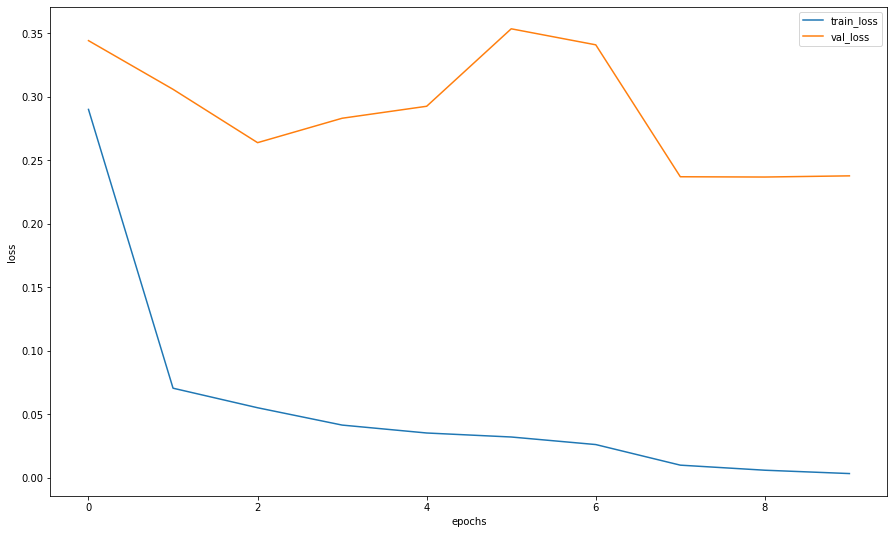

In [46]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Создадим файл посылки на Kaggle

In [47]:
import pandas as pd
my_submit = pd.DataFrame(columns=['Id', 'Expected'])
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()


,Id,Expected


In [48]:
test_dataset = SimpsonsDataset(test_files, mode='test')

In [49]:
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

In [50]:
with open('/kaggle/working/label_encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)

In [51]:
probs = predict(model, test_loader)

In [52]:
preds = encoder.inverse_transform(probs.argmax(axis=-1))

In [53]:
test_filenames = [path.name for path in test_dataset.files]

In [54]:
my_submit['Id'] = test_filenames
my_submit['Expected'] = preds

In [55]:
my_submit.to_csv('effnet.csv', index=False)